In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
data=pd.read_csv('15mindata.csv')

In [ ]:
data.head()

,DateTimeLogged,Area,TripDistance,duration,TotalFare,speed
0,2021-01-01 00:00:00,3,89921,2.166944,237.0,41496.679913
1,2021-01-01 00:15:00,3,47035,1.336667,148.5,35188.279302
2,2021-01-01 00:30:00,3,86311,2.924167,258.5,29516.443431
3,2021-01-01 00:45:00,3,71443,2.185000,210.0,32697.025172
4,2021-01-01 01:00:00,3,29960,0.865556,94.0,34613.607189


In [ ]:
format="%Y-%m-%d %H:%M:%S"
data['DateTimeLogged'] = pd.to_datetime(data['DateTimeLogged'],format=format)
data = data.set_index(pd.DatetimeIndex(data['DateTimeLogged']))
data = data.drop(['DateTimeLogged'], axis=1)

In [ ]:
data.shape

(259196, 5)

In [ ]:
# the following areas are the busiest places sorted by availability of trips every 17 minutes
selected_locations=[55,  86, 103,  46, 102,  57,  83,  28,   5,   3, 118,  77,  41,
            112,  11,   8, 114, 111, 115,  84, 116,  82,  14,  36,   9,  27,
             12,  73, 107,  71]

In [ ]:
series_by_loc_dict = {loca:data.query(f"Area == {loca}") for loca in selected_locations}

In [ ]:
series_by_loc_dict[82].head()

,Area,TripDistance,duration,TotalFare,speed
DateTimeLogged,,,,,
2021-01-01 00:00:00,82,630998,20.655833,1620.51,30548.174446
2021-01-01 00:15:00,82,1275255,40.930833,3263.54,31156.340982
2021-01-01 00:30:00,82,855844,22.181667,2093.50,38583.394695
2021-01-01 00:45:00,82,896610,25.056389,2290.03,35783.687904
2021-01-01 01:00:00,82,1050856,23.964167,2505.00,43851.138853


In [ ]:
import copy

df_by_loc={}

for loc in selected_locations:
    key_name='loc_df_'+str(loc)
    df_by_loc[key_name]=copy.deepcopy(series_by_loc_dict[loc])
    

In [ ]:

train_by_loc={}
test_by_loc={}

for loc in selected_locations:
    key_name_train='train_'+str(loc)
    key_name_test='test'+str(loc)
    train_by_loc[key_name_train]=copy.deepcopy(df_by_loc[f'loc_df_{loc}']["2021-01":"2021-03-20"].TotalFare)
    test_by_loc[key_name_test]=copy.deepcopy(df_by_loc[f'loc_df_{loc}']["2021-03-21":"2021-03-31"].TotalFare)



In [ ]:
loc82_dfl = data.query("Area == 82").drop("Area", axis=1)
loc111_dfl = data.query("Area == 111").drop("Area", axis=1)
loc116_dfl = data.query("Area == 116").drop("Area", axis=1)
loc11_dfl = data.query("Area == 11").drop("Area", axis=1)


In [ ]:
%%time
train_82 = loc82_dfl["2021-01":"2021-03-20"].iloc[:, [0,1,2,3]]
test_82 = loc82_dfl["2021-03-21":"2021-03-31"].iloc[:, [0,1,2,3]]

train_111 = loc111_dfl["2021-01":"2021-03-20"].iloc[:, [0,1,2,3]]
test_111 = loc111_dfl["2021-03-21":"2021-03-31"].iloc[:, [0,1,2,3]]

train_116 = loc116_dfl["2021-01":"2021-03-20"].iloc[:, [0,1,2,3]]
test_116 = loc116_dfl["2021-03-21":"2021-03-31"].iloc[:, [0,1,2,3]]

train_11 = loc11_dfl["2021-01":"2021-03-20"].iloc[:, [0,1,2,3]]
test_11 = loc11_dfl["2021-03-21":"2021-03-31"].iloc[:, [0,1,2,3]]

CPU times: user 22.1 ms, sys: 1.76 ms, total: 23.9 ms
Wall time: 23.3 ms


In [ ]:
train_by_loc['train_82'].values.reshape(-1,1)

array([[1620.51],
       [3263.54],
       [2093.5 ],
       ...,
       [1043.  ],
       [ 741.01],
       [1258.52]])

In [ ]:
test_by_loc['test82'].values

array([ 970.51,  855.51,  783.52, ..., 2173.52, 1289.51,  158.01])

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.is_available()


True

In [ ]:
torch.cuda.set_device(0)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #0


In [ ]:
train_by_loc['train_82']

DateTimeLogged
2021-01-01 00:00:00    1620.51
2021-01-01 00:15:00    3263.54
2021-01-01 00:30:00    2093.50
2021-01-01 00:45:00    2290.03
2021-01-01 01:00:00    2505.00
                        ...   
2021-03-20 22:45:00    1132.51
2021-03-20 23:00:00     801.51
2021-03-20 23:15:00    1043.00
2021-03-20 23:30:00     741.01
2021-03-20 23:45:00    1258.52
Name: TotalFare, Length: 7584, dtype: float64

In [ ]:
train_by_loc['train_82'][0:7584]


DateTimeLogged
2021-01-01 00:00:00    1620.51
2021-01-01 00:15:00    3263.54
2021-01-01 00:30:00    2093.50
2021-01-01 00:45:00    2290.03
2021-01-01 01:00:00    2505.00
                        ...   
2021-03-20 22:45:00    1132.51
2021-03-20 23:00:00     801.51
2021-03-20 23:15:00    1043.00
2021-03-20 23:30:00     741.01
2021-03-20 23:45:00    1258.52
Name: TotalFare, Length: 7584, dtype: float64

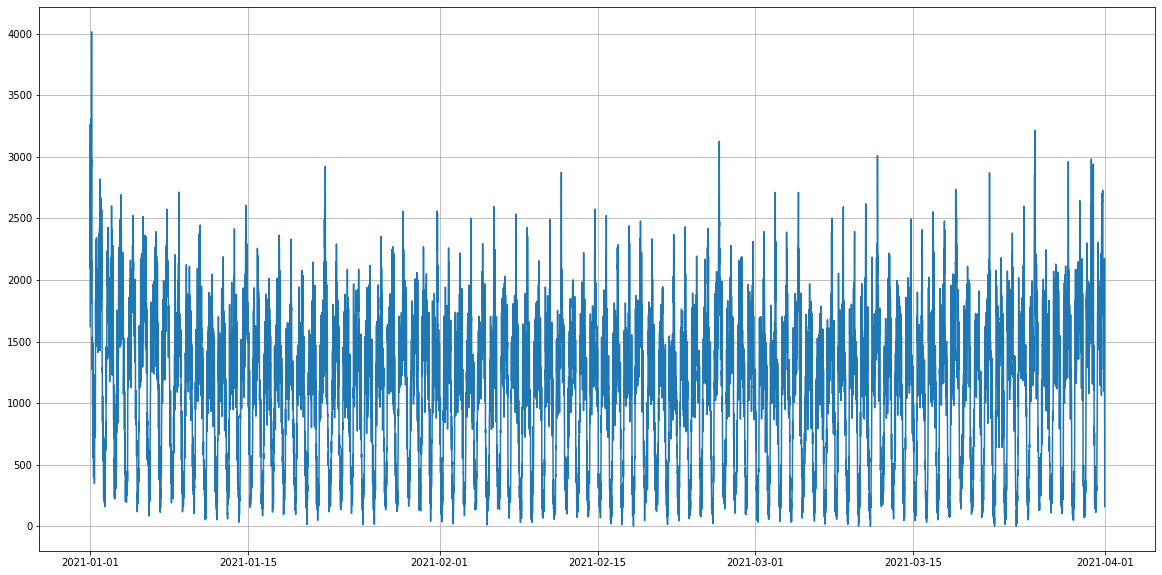

In [ ]:
data_set_82 = train_by_loc['train_82'].append(test_by_loc['test82'])
#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.rcParams['figure.figsize'] = [20, 10]
plt.grid()
plt.plot(data_set_82, label = 'Data for location 82')
plt.show()

In [ ]:
def create_seq(data,seq_length):
  x=[]
  y=[]
  for i in range(len(data)-seq_length-1):
    xx=data[i:(i+seq_length)]
    yy=data[i+seq_length]
    x.append(xx)
    y.append(yy)

  return np.array(x),np.array(y)
  

In [ ]:
# def create_dataset(dataset, seq_length):
# 	dataX, dataY = [], []
# 	for i in range(len(dataset)-seq_length-1):
# 		a = dataset[i:(i+seq_length), 0]
# 		dataX.append(a)
# 		dataY.append(dataset[i + seq_length, 0])
# 	return np.array(dataX), np.array(dataY)

In [ ]:
# def sampling(sequence, seq_length):
# 	X, Y = list(), list()
# 	for i in range(len(sequence)):
# 		sam = i + seq_length
# 		if sam > len(sequence)-1:
# 			break
# 		x, y = sequence[i:sam], sequence[sam]
# 		X.append(x)
# 		Y.append(y)
# 	return np.array(X), np.array(Y)

In [ ]:
# def create_inout_sequences(input_data, seq_length):
#     # inout_seq = []
#     dataX, dataY = [], []
#     L = len(input_data)
#     for i in range(L-seq_length):
#         train_seq = input_data[i:i+seq_length]
#         train_label = input_data[i+seq_length:i+seq_length+1]
#         dataX.append(train_seq)
#         dataY.append(train_label)
#         # inout_seq.append((train_seq ,train_label))
#     # return inout_seq
#     return np.array(dataX), np.array(dataY)

In [ ]:
mm=MinMaxScaler()
data_set_82_normalized=mm.fit_transform(data_set_82.values.reshape(-1,1))

seq_length = 4
x_82, y_82 = create_seq(data_set_82_normalized, seq_length)

train_size = 7584
test_size = len(y_82) - train_size

dataX_82 = Variable(torch.Tensor(np.array(x_82)))
dataY_82 = Variable(torch.Tensor(np.array(y_82)))

trainX_82 = Variable(torch.Tensor(np.array(x_82[0:train_size])))
trainY_82 = Variable(torch.Tensor(np.array(y_82[0:train_size])))

testX_82 = Variable(torch.Tensor(np.array(x_82[train_size:len(x_82)])))
testY_82 = Variable(torch.Tensor(np.array(y_82[train_size:len(y_82)])))


In [ ]:
len(x_82)

8635

In [ ]:
# mm=MinMaxScaler()
# training_data_82=mm.fit_transform(train_by_loc['train_82'].values.reshape(-1,1))
# training_data_116=mm.fit_transform(train_by_loc['train_116'].values.reshape(-1,1))
# training_data_111=mm.fit_transform(train_by_loc['train_111'].values.reshape(-1,1))
# training_data_11=mm.fit_transform(train_by_loc['train_11'].values.reshape(-1,1))

# test_data_82=mm.fit_transform(test_by_loc['test82'].values.reshape(-1,1))
# test_data_116=mm.fit_transform(test_by_loc['test116'].values.reshape(-1,1))
# test_data_111=mm.fit_transform(test_by_loc['test111'].values.reshape(-1,1))
# test_data_11=mm.fit_transform(test_by_loc['test11'].values.reshape(-1,1))

In [ ]:
# seq_len=48
# xn_82,yn_82=create_seq(training_data_82,seq_len)
# xt_82,yt_82=create_seq(test_data_82,seq_len)

# #train tensor for loc 82
# train_tensorx_82=Variable(torch.Tensor(np.array(xn_82)))
# train_tensory_82=Variable(torch.Tensor(np.array(yn_82)))

# #test tensor for loc 82
# test_tensorx_82=Variable(torch.Tensor(np.array(xt_82)))
# test_tesnory_82=Variable(torch.Tensor(np.array(yt_82)))


In [ ]:
class LSTM(nn.Module):

  def __init__(self, num_classes, input_size, hidden_size, num_layers):
    super(LSTM,self).__init__()

    self.num_classes=num_classes
    self.num_layers=num_layers
    self.input_size=input_size
    self.hidden_size=hidden_size
    self.seq_len=seq_len

    self.lstm=nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)

    self.fc=nn.Linear(hidden_size,num_classes)

  def forward(self,x):
    h_0=Variable(torch.zeros(self.num_layers, x.size(0),self.hidden_size))

    c_0=Variable(torch.zeros(self.num_layers, x.size(0),self.hidden_size))

    ula, (h_out, _)=self.lstm(x, (h_0, c_0))

    h_out = h_out.view(-1, self.hidden_size)

    out = self.fc(h_out)

    return out

In [ ]:
seq_len=4
num_epochs=500
learning_rate=0.01

input_size=1
hidden_size=100
num_layers=1
num_classes=1

lstm=LSTM(num_classes, input_size,hidden_size,num_layers)
print(lstm)
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(lstm.parameters(),lr=learning_rate)


LSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
for epoch in range(num_epochs):
  outputs_82=lstm(trainX_82)
  optimizer.zero_grad()

  loss=criterion(outputs_82,trainY_82)
  loss.backward()

  optimizer.step()
  if epoch % 25 == 0:
    print("Epoch: %d, loss: %1.5f" %(epoch,loss.item()))

Epoch: 0, loss: 0.12967
Epoch: 25, loss: 0.01108
Epoch: 50, loss: 0.00490
Epoch: 75, loss: 0.00473
Epoch: 100, loss: 0.00460
Epoch: 125, loss: 0.00452
Epoch: 150, loss: 0.00446
Epoch: 175, loss: 0.00442
Epoch: 200, loss: 0.00440
Epoch: 225, loss: 0.00439
Epoch: 250, loss: 0.00438
Epoch: 275, loss: 0.00438
Epoch: 300, loss: 0.00437
Epoch: 325, loss: 0.00437
Epoch: 350, loss: 0.00437
Epoch: 375, loss: 0.00436
Epoch: 400, loss: 0.00436
Epoch: 425, loss: 0.00435
Epoch: 450, loss: 0.00435
Epoch: 475, loss: 0.00434


In [ ]:
lstm.eval()

train_82_predict=lstm(dataX_82)

train_82_predicted_values=train_82_predict.data.numpy()
train_82_plot=dataY_82.data.numpy()

train_82_predicted_values=mm.inverse_transform(train_82_predicted_values)
train_82_plot=mm.inverse_transform(train_82_plot)

# plt.axvline(x=len(train_by_loc['train_82']), c='r', linestyle='--')

# # data_set_82 = train_by_loc['train_82'].append(test_by_loc['test82'])
# #plt.plot(training_set, label = 'Shampoo Sales Data')
# plt.rcParams['figure.figsize'] = [30, 10]
# plt.grid()
# # plt.plot(data_set_82, label = 'Data for location 82')
# # plt.show()
# t=data_set_82.index.values[5:]
# values=range(8635)
# plt.plot(values,train_82_plot,marker="o")
# plt.plot(values,train_82_predicted_values,marker="x")
# plt.suptitle('Predictions for location 82')
# plt.xticks(range(8635),t)
# plt.show()

In [ ]:
data_set_82

DateTimeLogged
2021-01-01 00:00:00    1620.51
2021-01-01 00:15:00    3263.54
2021-01-01 00:30:00    2093.50
2021-01-01 00:45:00    2290.03
2021-01-01 01:00:00    2505.00
                        ...   
2021-03-31 22:45:00    1093.01
2021-03-31 23:00:00    1829.04
2021-03-31 23:15:00    2173.52
2021-03-31 23:30:00    1289.51
2021-03-31 23:45:00     158.01
Name: TotalFare, Length: 8640, dtype: float64

In [ ]:
train_82_predicted_values

array([[2137.4097],
       [2214.5137],
       [2526.7234],
       ...,
       [1276.7115],
       [1518.6315],
       [1801.9838]], dtype=float32)

In [ ]:
train_82_plot[7579:]

array([[1258.52],
       [ 970.51],
       [ 855.51],
       ...,
       [1829.04],
       [2173.52],
       [1289.51]], dtype=float32)

In [ ]:
from sklearn.metrics import mean_absolute_error
train_82_error=mean_absolute_error(np.array(train_82_plot[:7579]),np.array(train_82_predicted_values[:7579]))
print(train_82_error)
test_82_error=mean_absolute_error(np.array(train_82_plot[7579:]),np.array(train_82_predicted_values[7579:]))
print(test_82_error)

203.16309
220.04713


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_82_error=sqrt(mean_squared_error(np.array(train_82_plot[:7579]),np.array(train_82_predicted_values[:7579])))
print(train_82_error)
test_82_error=sqrt(mean_squared_error(np.array(train_82_plot[7579:]),np.array(train_82_predicted_values[7579:])))
print(test_82_error)

264.090523660922
288.83794656346663


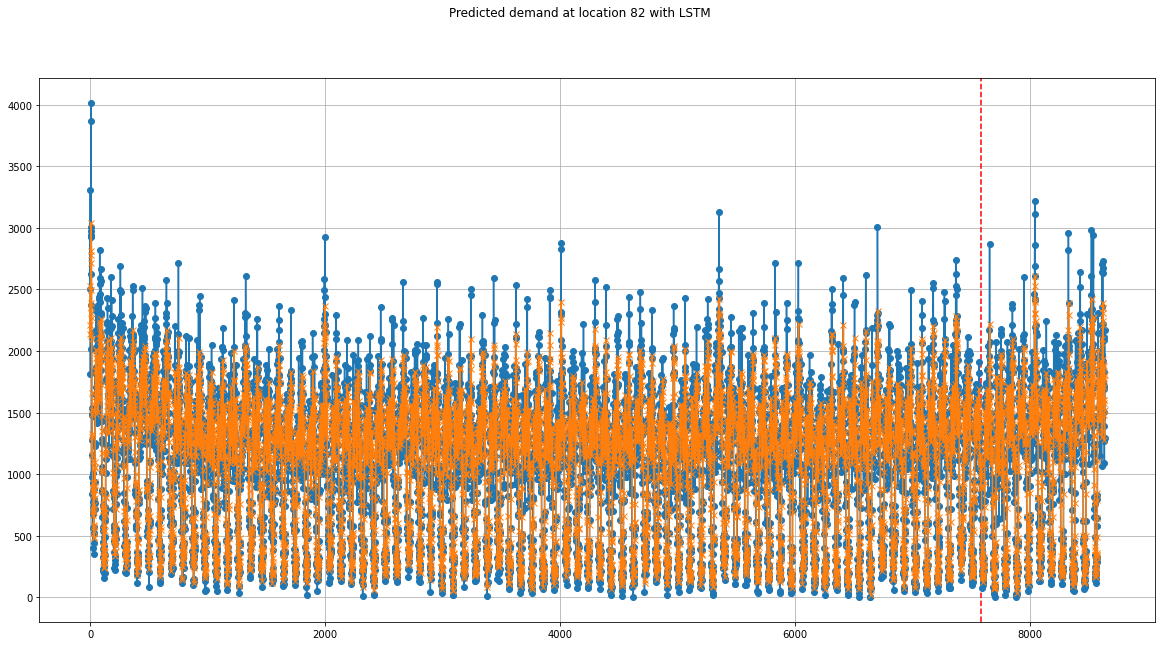

In [ ]:
plt.axvline(x=len(train_by_loc['train_82']), c='r', linestyle='--')

# data_set_82 = train_by_loc['train_82'].append(test_by_loc['test82'])
#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.rcParams['figure.figsize'] = [20, 10]
plt.grid()
# plt.plot(data_set_82, label = 'Data for location 82')
# plt.show()
# t=data_set_82.index.values[5:]
# values=range(8635)
plt.plot(train_82_plot,label='Actual Data',marker="o")
plt.plot(train_82_predicted_values,label='Predicted Data', marker="x")
plt.suptitle('Predicted demand at location 82 with LSTM')
# plt.xticks(range(8635),t)
plt.show()

In [ ]:
len(train_82_plot)
len(train_82_predicted_values)


8635

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.plot(data_set_82[7595:].index.values,
#         train_82_plot[7595:],
#         '-o',
#         color='purple')
# ax.plot(data_set_82[7595:].index.values,
#         train_82_predicted_values[7595:],
#         '-x',
#         color='orange')

# ax.set(xlabel="Date", ylabel="TotalFare",
#        title="Demand at location 82 with LSTM")
# plt.grid()

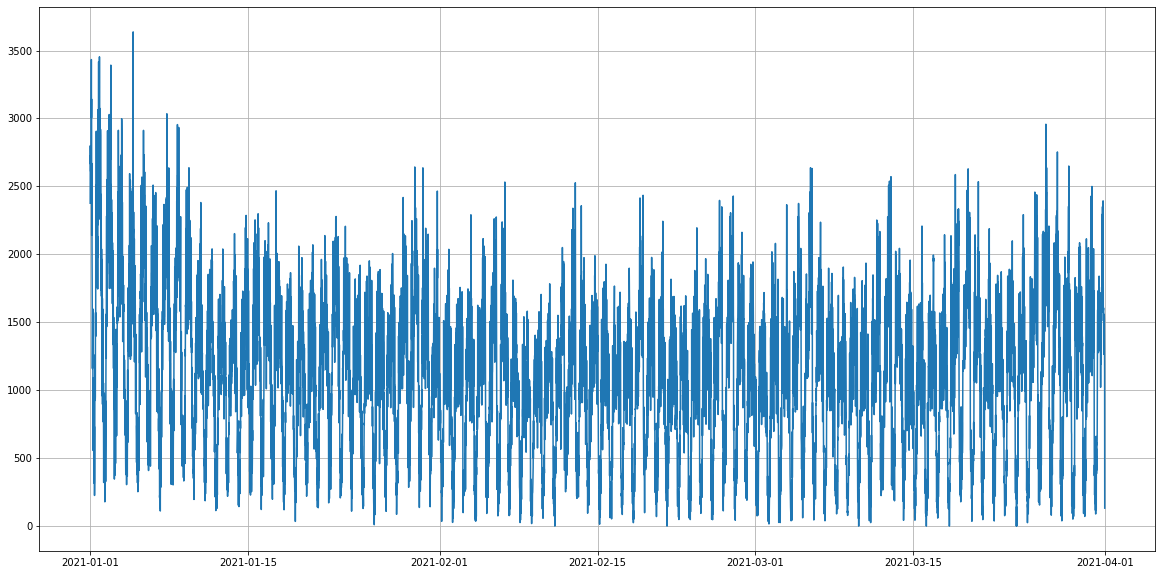

In [ ]:
data_set_116 = train_by_loc['train_116'].append(test_by_loc['test116'])
#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.rcParams['figure.figsize'] = [20, 10]
plt.grid()
plt.plot(data_set_116, label = 'Data for location 116')
plt.show()

In [ ]:
mm=MinMaxScaler()
data_set_116_normalized=mm.fit_transform(data_set_116.values.reshape(-1,1))

seq_length = 4
x_116, y_116 = create_seq(data_set_116_normalized, seq_length)

train_size = 7584
test_size = len(y_116) - train_size

dataX_116 = Variable(torch.Tensor(np.array(x_116)))
dataY_116 = Variable(torch.Tensor(np.array(y_116)))

trainX_116 = Variable(torch.Tensor(np.array(x_116[0:train_size])))
trainY_116 = Variable(torch.Tensor(np.array(y_116[0:train_size])))

testX_116 = Variable(torch.Tensor(np.array(x_116[train_size:len(x_116)])))
testY_116 = Variable(torch.Tensor(np.array(y_116[train_size:len(y_116)])))


In [ ]:
for epoch in range(num_epochs):
  outputs_116=lstm(trainX_116)
  optimizer.zero_grad()

  loss=criterion(outputs_116,trainY_116)
  loss.backward()

  optimizer.step()
  if epoch % 25 == 0:
    print("Epoch: %d, loss: %1.5f" %(epoch,loss.item()))

Epoch: 0, loss: 0.00628
Epoch: 25, loss: 0.00615
Epoch: 50, loss: 0.00615
Epoch: 75, loss: 0.00614
Epoch: 100, loss: 0.00614
Epoch: 125, loss: 0.00614
Epoch: 150, loss: 0.00614
Epoch: 175, loss: 0.00613
Epoch: 200, loss: 0.00613
Epoch: 225, loss: 0.00613
Epoch: 250, loss: 0.00613
Epoch: 275, loss: 0.00613
Epoch: 300, loss: 0.00612
Epoch: 325, loss: 0.00612
Epoch: 350, loss: 0.00611
Epoch: 375, loss: 0.00612
Epoch: 400, loss: 0.00611
Epoch: 425, loss: 0.00611
Epoch: 450, loss: 0.00610
Epoch: 475, loss: 0.00610


In [ ]:
lstm.eval()

train_116_predict=lstm(dataX_116)

train_116_predicted_values=train_116_predict.data.numpy()
train_116_plot=dataY_116.data.numpy()

train_116_predicted_values=mm.inverse_transform(train_116_predicted_values)
train_116_plot=mm.inverse_transform(train_116_plot)

In [ ]:
from sklearn.metrics import mean_absolute_error
train_116_error=mean_absolute_error(np.array(train_116_plot[:7579]),np.array(train_116_predicted_values[:7579]))
print(train_116_error)
test_116_error=mean_absolute_error(np.array(train_116_plot[7579:]),np.array(train_116_predicted_values[7579:]))
print(test_116_error)

222.05861
225.1242


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_116_error=sqrt(mean_squared_error(np.array(train_116_plot[:7579]),np.array(train_116_predicted_values[:7579])))
print(train_116_error)
test_116_error=sqrt(mean_squared_error(np.array(train_116_plot[7579:]),np.array(train_116_predicted_values[7579:])))
print(test_116_error)

283.9644013780601
289.0205712834296


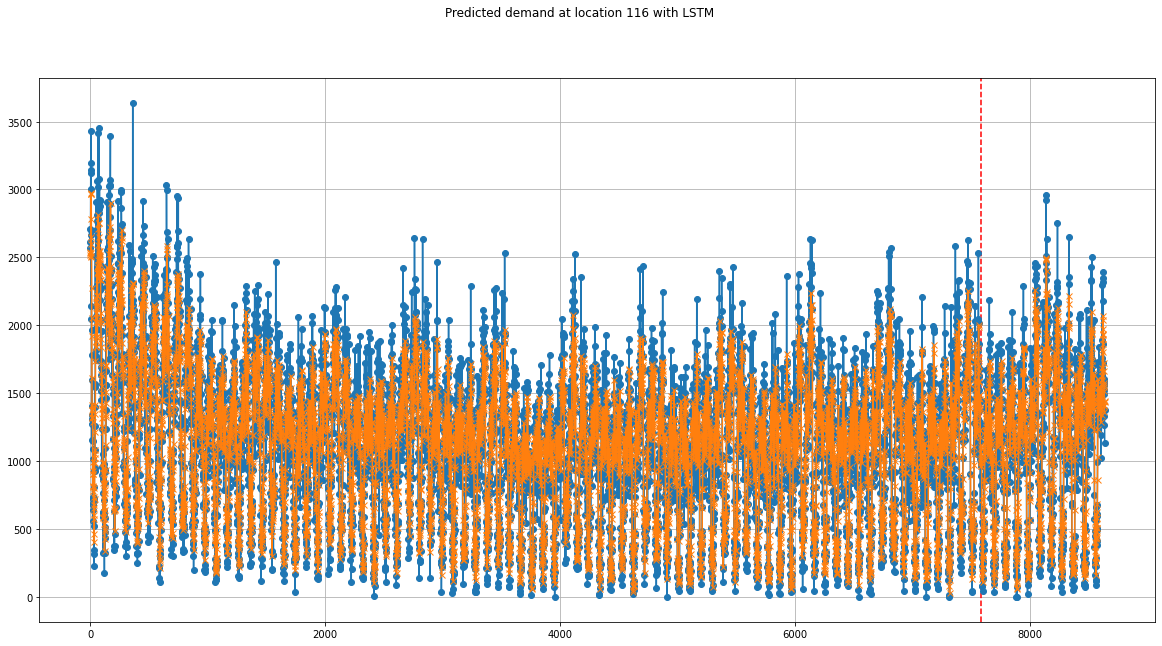

In [ ]:
plt.axvline(x=len(train_by_loc['train_82']), c='r', linestyle='--')

# data_set_82 = train_by_loc['train_82'].append(test_by_loc['test82'])
#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.rcParams['figure.figsize'] = [20, 10]
plt.grid()
# plt.plot(data_set_82, label = 'Data for location 82')
# plt.show()
# t=data_set_82.index.values[5:]
# values=range(8635)
plt.plot(train_116_plot,label='Actual Data',marker="o")
plt.plot(train_116_predicted_values,label='Predicted Data', marker="x")
plt.suptitle('Predicted demand at location 116 with LSTM')
# plt.xticks(range(8635),t)
plt.show()

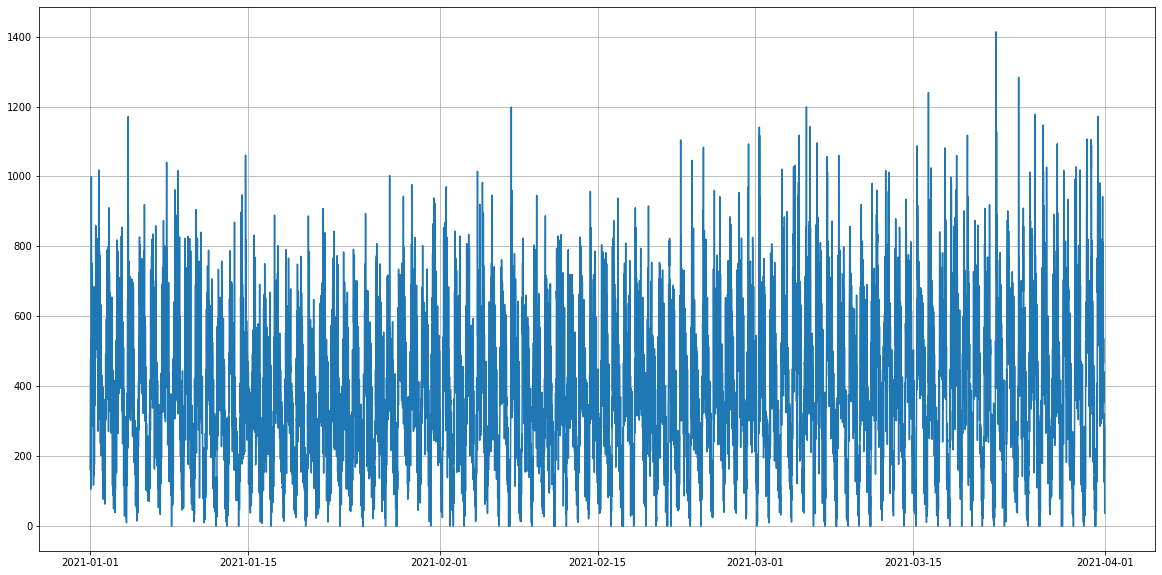

In [ ]:
data_set_111 = train_by_loc['train_111'].append(test_by_loc['test111'])
#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.rcParams['figure.figsize'] = [20, 10]
plt.grid()
plt.plot(data_set_111, label = 'Data for location 111')
plt.show()

In [ ]:
mm=MinMaxScaler()
data_set_111_normalized=mm.fit_transform(data_set_111.values.reshape(-1,1))

seq_length = 4
x_111, y_111 = create_seq(data_set_111_normalized, seq_length)

train_size = 7584
test_size = len(y_111) - train_size

dataX_111 = Variable(torch.Tensor(np.array(x_111)))
dataY_111 = Variable(torch.Tensor(np.array(y_111)))

trainX_111 = Variable(torch.Tensor(np.array(x_111[0:train_size])))
trainY_111 = Variable(torch.Tensor(np.array(y_111[0:train_size])))

testX_111 = Variable(torch.Tensor(np.array(x_111[train_size:len(x_111)])))
testY_111 = Variable(torch.Tensor(np.array(y_111[train_size:len(y_111)])))


In [ ]:
for epoch in range(num_epochs):
  outputs_111=lstm(trainX_111)
  optimizer.zero_grad()

  loss=criterion(outputs_111,trainY_111)
  loss.backward()

  optimizer.step()
  if epoch % 25 == 0:
    print("Epoch: %d, loss: %1.5f" %(epoch,loss.item()))

Epoch: 0, loss: 0.01149
Epoch: 25, loss: 0.01103
Epoch: 50, loss: 0.01098
Epoch: 75, loss: 0.01095
Epoch: 100, loss: 0.01093
Epoch: 125, loss: 0.01093
Epoch: 150, loss: 0.01092
Epoch: 175, loss: 0.01092
Epoch: 200, loss: 0.01092
Epoch: 225, loss: 0.01092
Epoch: 250, loss: 0.01092
Epoch: 275, loss: 0.01091
Epoch: 300, loss: 0.01091
Epoch: 325, loss: 0.01091
Epoch: 350, loss: 0.01091
Epoch: 375, loss: 0.01091
Epoch: 400, loss: 0.01091
Epoch: 425, loss: 0.01091
Epoch: 450, loss: 0.01091
Epoch: 475, loss: 0.01091


In [ ]:
lstm.eval()

train_111_predict=lstm(dataX_111)

train_111_predicted_values=train_111_predict.data.numpy()
train_111_plot=dataY_111.data.numpy()

train_111_predicted_values=mm.inverse_transform(train_111_predicted_values)
train_111_plot=mm.inverse_transform(train_111_plot)

In [ ]:
from sklearn.metrics import mean_absolute_error
train_111_error=mean_absolute_error(np.array(train_111_plot[:7579]),np.array(train_111_predicted_values[:7579]))
print(train_111_error)
test_111_error=mean_absolute_error(np.array(train_111_plot[7579:]),np.array(train_111_predicted_values[7579:]))
print(test_111_error)

114.80262
126.27013


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_111_error=sqrt(mean_squared_error(np.array(train_111_plot[:7579]),np.array(train_111_predicted_values[:7579])))
print(train_111_error)
test_111_error=sqrt(mean_squared_error(np.array(train_111_plot[7579:]),np.array(train_111_predicted_values[7579:])))
print(test_111_error)

147.85693703078323
166.33137106390964


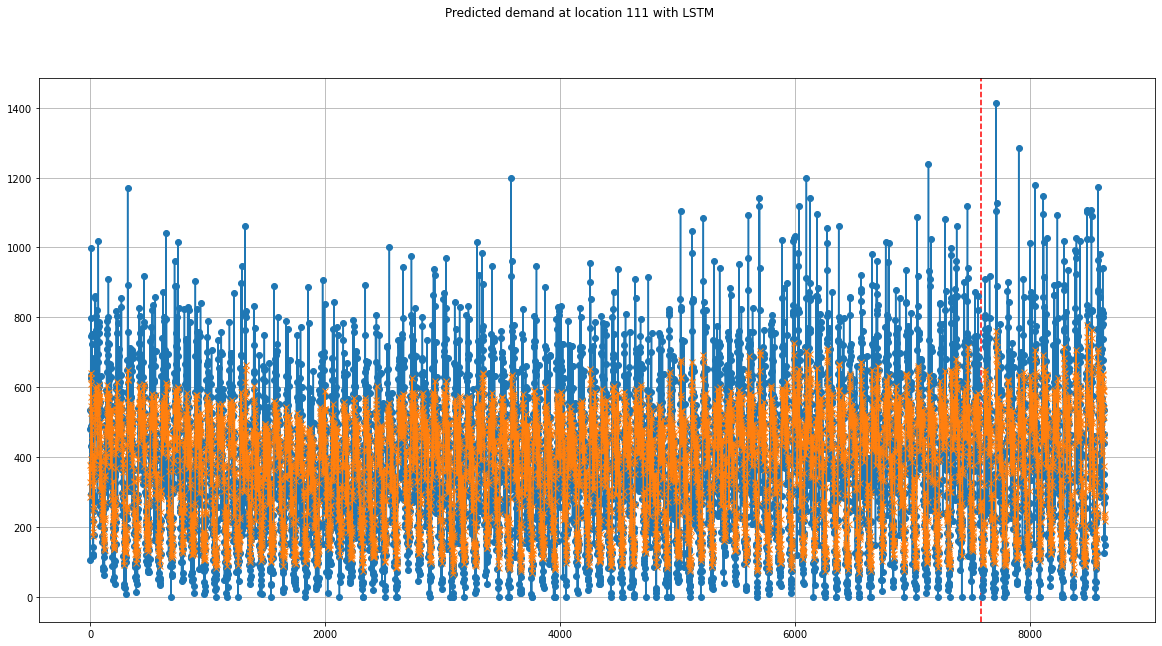

In [ ]:
plt.axvline(x=len(train_by_loc['train_82']), c='r', linestyle='--')

# data_set_82 = train_by_loc['train_82'].append(test_by_loc['test82'])
#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.rcParams['figure.figsize'] = [20, 10]
plt.grid()
# plt.plot(data_set_82, label = 'Data for location 82')
# plt.show()
# t=data_set_82.index.values[5:]
# values=range(8635)
plt.plot(train_111_plot,label='Actual Data',marker="o")
plt.plot(train_111_predicted_values,label='Predicted Data', marker="x")
plt.suptitle('Predicted demand at location 111 with LSTM')
# plt.xticks(range(8635),t)
plt.show()

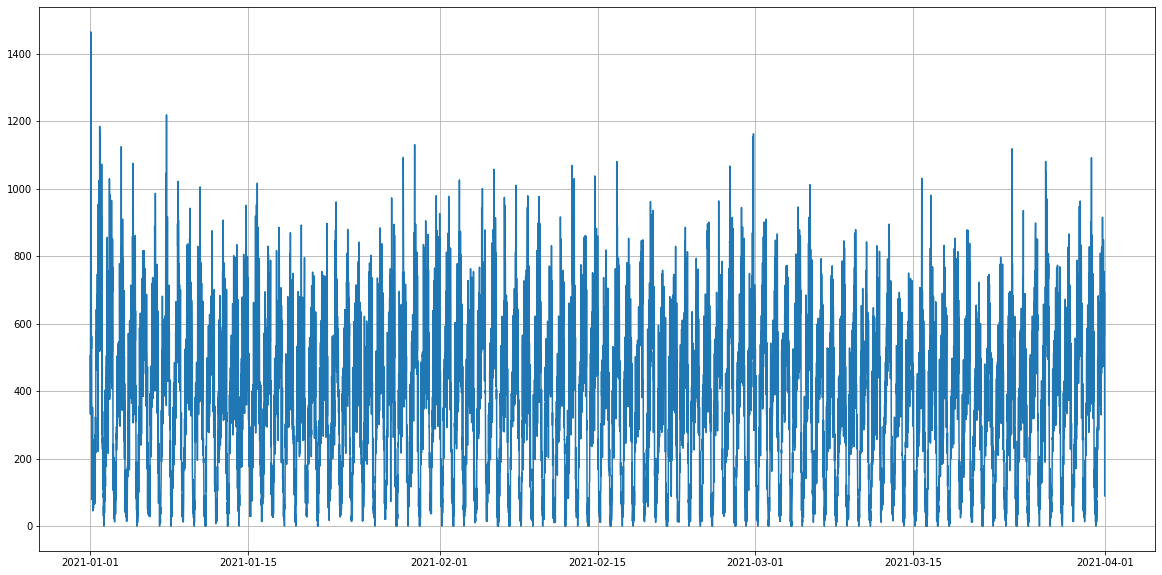

In [ ]:
data_set_11 = train_by_loc['train_11'].append(test_by_loc['test11'])
#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.rcParams['figure.figsize'] = [20, 10]
plt.grid()
plt.plot(data_set_11, label = 'Data for location 11')
plt.show()

In [ ]:
mm=MinMaxScaler()
data_set_11_normalized=mm.fit_transform(data_set_11.values.reshape(-1,1))

seq_length = 4
x_11, y_11 = create_seq(data_set_11_normalized, seq_length)

train_size = 7584
test_size = len(y_11) - train_size

dataX_11 = Variable(torch.Tensor(np.array(x_11)))
dataY_11 = Variable(torch.Tensor(np.array(y_11)))

trainX_11 = Variable(torch.Tensor(np.array(x_11[0:train_size])))
trainY_11 = Variable(torch.Tensor(np.array(y_11[0:train_size])))

testX_11 = Variable(torch.Tensor(np.array(x_11[train_size:len(x_11)])))
testY_11 = Variable(torch.Tensor(np.array(y_11[train_size:len(y_11)])))


In [ ]:
for epoch in range(num_epochs):
  outputs_11=lstm(trainX_11)
  optimizer.zero_grad()

  loss=criterion(outputs_11,trainY_11)
  loss.backward()

  optimizer.step()
  if epoch % 25 == 0:
    print("Epoch: %d, loss: %1.5f" %(epoch,loss.item()))

Epoch: 0, loss: 0.00833
Epoch: 25, loss: 0.00808
Epoch: 50, loss: 0.00805
Epoch: 75, loss: 0.00803
Epoch: 100, loss: 0.00802
Epoch: 125, loss: 0.00802
Epoch: 150, loss: 0.00801
Epoch: 175, loss: 0.00801
Epoch: 200, loss: 0.00800
Epoch: 225, loss: 0.00800
Epoch: 250, loss: 0.00800
Epoch: 275, loss: 0.00800
Epoch: 300, loss: 0.00800
Epoch: 325, loss: 0.00800
Epoch: 350, loss: 0.00800
Epoch: 375, loss: 0.00800
Epoch: 400, loss: 0.00800
Epoch: 425, loss: 0.00799
Epoch: 450, loss: 0.00799
Epoch: 475, loss: 0.00801


In [ ]:
lstm.eval()

train_11_predict=lstm(dataX_11)

train_11_predicted_values=train_11_predict.data.numpy()
train_11_plot=dataY_11.data.numpy()

train_11_predicted_values=mm.inverse_transform(train_11_predicted_values)
train_11_plot=mm.inverse_transform(train_11_plot)

In [ ]:
from sklearn.metrics import mean_absolute_error
train_11_error=mean_absolute_error(np.array(train_11_plot[:7579]),np.array(train_11_predicted_values[:7579]))
print(train_11_error)
test_11_error=mean_absolute_error(np.array(train_11_plot[7579:]),np.array(train_11_predicted_values[7579:]))
print(test_11_error)

99.75929
95.938805


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_11_error=sqrt(mean_squared_error(np.array(train_11_plot[:7579]),np.array(train_11_predicted_values[:7579])))
print(train_11_error)
test_11_error=sqrt(mean_squared_error(np.array(train_11_plot[7579:]),np.array(train_11_predicted_values[7579:])))
print(test_11_error)

130.97332445482934
126.38426106644965


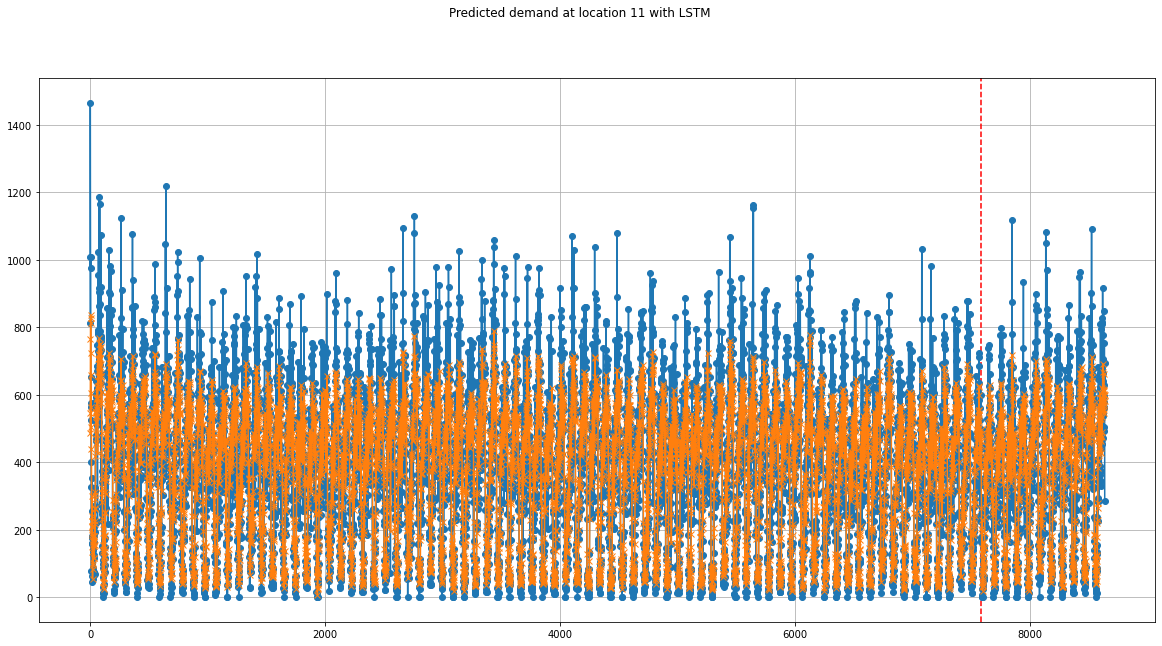

In [ ]:
plt.axvline(x=len(train_by_loc['train_82']), c='r', linestyle='--')

# data_set_82 = train_by_loc['train_82'].append(test_by_loc['test82'])
#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.rcParams['figure.figsize'] = [20, 10]
plt.grid()
# plt.plot(data_set_82, label = 'Data for location 82')
# plt.show()
# t=data_set_82.index.values[5:]
# values=range(8635)
plt.plot(train_11_plot,label='Actual Data',marker="o")
plt.plot(train_11_predicted_values,label='Predicted Data', marker="x")
plt.suptitle('Predicted demand at location 11 with LSTM')
# plt.xticks(range(8635),t)
plt.show()